<a href="https://colab.research.google.com/github/migdashn/Deep-Learning-Projects/blob/main/tts_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#IMPORTS

In [22]:
import torch
import torch.multiprocessing as mp
import torch.distributed as dist
import torch.utils.data.distributed
from torch.utils import data
from torch.utils.data import Dataset, DataLoader, TensorDataset
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR 
import torch.nn.functional as F
from torch import Tensor
import math
from scipy import io
import pandas as pd

#from utils.torch_fid_score import get_fid
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from copy import deepcopy
import random 
import matplotlib.pyplot as plt
#import io
import PIL.Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#GAN Model

In [24]:
class Generator(nn.Module):
    def __init__(self, seq_len=900, patch_size=15, channels=1, num_classes=9, latent_dim=100, embed_dim=10, depth=3,
                 num_heads=5, forward_drop_rate=0.5, attn_drop_rate=0.5):
        super(Generator, self).__init__()
        self.channels = channels
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.depth = depth
        self.attn_drop_rate = attn_drop_rate
        self.forward_drop_rate = forward_drop_rate
        
        self.l1 = nn.Linear(self.latent_dim, self.seq_len * self.embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.seq_len, self.embed_dim))
        self.blocks = Gen_TransformerEncoder(
                         depth=self.depth,
                         emb_size = self.embed_dim,
                         drop_p = self.attn_drop_rate,
                         forward_drop_p=self.forward_drop_rate
                        )

        self.deconv = nn.Sequential(
            nn.Conv2d(self.embed_dim, self.channels, 1, 1, 0)
        )

    def forward(self, z):
        x = self.l1(z).view(-1, self.seq_len, self.embed_dim)
        x = x + self.pos_embed
        H, W = 1, self.seq_len
        x = self.blocks(x)
        x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
        output = self.deconv(x.permute(0, 3, 1, 2))
        output = output.view(-1, self.channels, H, W)
        return output
    
    
class Gen_TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 num_heads=5,
                 drop_p=0.5,
                 forward_expansion=4,
                 forward_drop_p=0.5):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

        
class Gen_TransformerEncoder(nn.Sequential):
    def __init__(self, depth=8, **kwargs):
        super().__init__(*[Gen_TransformerEncoderBlock(**kwargs) for _ in range(depth)])       
        
        
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)  # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

    
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x
    
    
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

        
        
class Dis_TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size=100,
                 num_heads=5,
                 drop_p=0.,
                 forward_expansion=4,
                 forward_drop_p=0.):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class Dis_TransformerEncoder(nn.Sequential):
    def __init__(self, depth=8, **kwargs):
        super().__init__(*[Dis_TransformerEncoderBlock(**kwargs) for _ in range(depth)])
        
        
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size=100, n_classes=2):
        super().__init__()
        self.clshead = nn.Sequential(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

    def forward(self, x):
        out = self.clshead(x)
        return out

    
class PatchEmbedding_Linear(nn.Module):
    #what are the proper parameters set here?
    def __init__(self, in_channels = 21, patch_size = 16, emb_size = 100, seq_length = 1024):
        # self.patch_size = patch_size
        super().__init__()
        #change the conv2d parameters here
        self.projection = nn.Sequential(
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)',s1 = 1, s2 = patch_size),
            nn.Linear(patch_size*in_channels, emb_size)
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((seq_length // patch_size) + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        #prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # position
        x += self.positions
        return x        
        
        
class Discriminator(nn.Sequential):
    def __init__(self, 
                 in_channels=1,
                 patch_size=15,
                 emb_size=50, 
                 seq_length = 900,
                 depth=3, 
                 n_classes=1, 
                 **kwargs):
        super().__init__(
            PatchEmbedding_Linear(in_channels, patch_size, emb_size, seq_length),
            Dis_TransformerEncoder(depth, emb_size=emb_size, drop_p=0.5, forward_drop_p=0.5, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
     

#Data loader

In [25]:
class SineWaveDataset(Dataset):
    def __init__(self, data_size):
        self.data_size = data_size
        self.x = np.linspace(0, 2*np.pi, self.data_size)
        self.y = np.sin(self.x)
        #real_y = y.type(torch.FloatTensor).to(device)

    def __len__(self):
        return self.data_size

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [52]:
def generate_sine_samples(seq_len, num_samples,batch_size):
    # Define the parameters of the sine wave
    #amplitude = np.random.uniform(0.3,1)
    #frequency = np.random.uniform(1,5)
    #phase = np.random.uniform(0, np.pi)
    noise = np.random.uniform(0, 0.1, batch_size)
    amplitude = 1
    frequency = 4
    phase = np.pi/10

    # Generate the x-values for the sine wave
    x = np.linspace(0, 2*np.pi, seq_len)

    # Create a tensor to store the sine waves
    #batch_size = 64
    sine_waves = torch.zeros((batch_size, 1, 1, seq_len))

    # Generate the sine waves and store them in the tensor
    for i in range(batch_size):
        #frequency = np.random.uniform(0.8,1)
        y = (0.2 * np.sin(frequency*x + phase) + 
             amplitude * np.sin(frequency*0.73*x + phase*1.1) + 
             0.5 * np.sin(frequency*1.6*x + phase*0.84))/3 + noise[i]
        sine_waves[i][0][0] = torch.from_numpy(y)
        #d =  torch.tensor(sine_waves, dtype=torch.float32)
    return sine_waves

#Utility functions

In [42]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        nn.init.xavier_uniform(m.weight.data, 1.)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [43]:
class LinearLrDecay(object):
    def __init__(self, optimizer, start_lr, end_lr, decay_start_step, decay_end_step):

        assert start_lr > end_lr
        self.optimizer = optimizer
        self.delta = (start_lr - end_lr) / (decay_end_step - decay_start_step)
        self.decay_start_step = decay_start_step
        self.decay_end_step = decay_end_step
        self.start_lr = start_lr
        self.end_lr = end_lr

    def step(self, current_step):
        if current_step <= self.decay_start_step:
            lr = self.start_lr
        elif current_step >= self.decay_end_step:
            lr = self.end_lr
        else:
            lr = self.start_lr - self.delta * (current_step - self.decay_start_step)
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        return lr

#Train

In [55]:
# Define the hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

torch.cuda.empty_cache()

batch_size = 64
num_epochs = 1501
g_lr = 0.002
d_lr = 0.003
latent_dim = 100
data_size = 100000
seq_len = 900
beta1 = 0.5
beta2 = 0.999
step_size = 100
gamma=0.1

dataset = torch.utils.data.TensorDataset(generate_sine_samples(seq_len, data_size, batch_size))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()

# Initialize the generator and discriminator models
generator = Generator(seq_len=seq_len, 
                      patch_size=15, 
                      channels=1, 
                      num_classes=9, 
                      latent_dim=100, 
                      embed_dim=10, 
                      depth=3,
                 num_heads=5, 
                 forward_drop_rate=0.5, 
                 attn_drop_rate=0.5).to(device)
#print(generator)
discriminator = Discriminator(in_channels=1,
                 patch_size=15,
                 emb_size=50, 
                 seq_length = seq_len,
                 depth=3, 
                 n_classes=1,).to(device)
#print(discriminator)


generator.apply(weights_init)
discriminator.apply(weights_init)

# Initialize the optimizers
#g_optimizer = optim.Adam(generator.parameters(), lr=g_lr, betas=(0.9, 0.999))
#d_optimizer = optim.Adam(discriminator.parameters(), lr=d_lr, betas=(0.9, 0.999))

g_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, generator.parameters()),
                              g_lr, (beta1, beta2))
d_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, discriminator.parameters()),
                              d_lr, (beta1, beta2))


#g_scheduler = StepLR(g_optimizer, step_size, gamma)
#d_scheduler = StepLR(d_optimizer, step_size, gamma)

g_scheduler = LinearLrDecay(g_optimizer, g_lr, 0.0, 0, num_epochs)
d_scheduler = LinearLrDecay(d_optimizer, d_lr, 0.0, 0, num_epochs)

torch.cuda.empty_cache()


cuda


<ipython-input-42-d4b529dfccca>:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data, 1.)


Epoch [0/1501] | d_loss: 0.7885 | g_loss: 10.9148
Epoch: 0 Generator Learning rate: 0.002
Epoch: 0 Discriminator Learning rate: 0.003


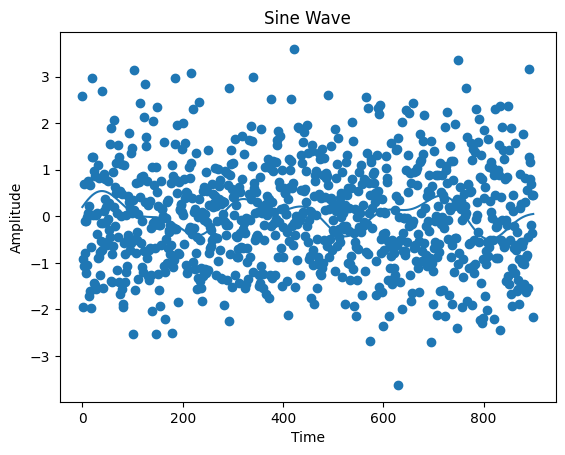

Epoch [10/1501] | d_loss: 1.1394 | g_loss: 0.4437
Epoch [20/1501] | d_loss: 1.3870 | g_loss: 0.1949
Epoch [30/1501] | d_loss: 0.7721 | g_loss: 0.2649
Epoch [40/1501] | d_loss: 0.2604 | g_loss: 0.5262
Epoch [50/1501] | d_loss: 0.3869 | g_loss: 0.4438
Epoch [60/1501] | d_loss: 0.4972 | g_loss: 0.2855
Epoch [70/1501] | d_loss: 0.5448 | g_loss: 0.2707
Epoch [80/1501] | d_loss: 0.3354 | g_loss: 0.1879
Epoch [90/1501] | d_loss: 0.5036 | g_loss: 0.5878
Epoch [100/1501] | d_loss: 0.2757 | g_loss: 0.2906
Epoch: 100 Generator Learning rate: 0.0018667554963357762
Epoch: 100 Discriminator Learning rate: 0.002800133244503664


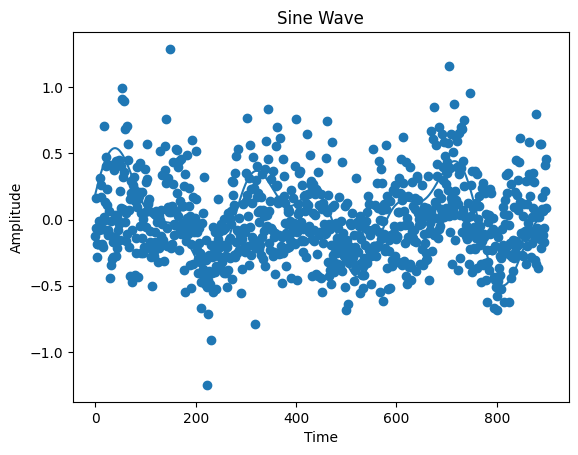

Epoch [110/1501] | d_loss: 0.2613 | g_loss: 0.5476
Epoch [120/1501] | d_loss: 0.2633 | g_loss: 0.2789
Epoch [130/1501] | d_loss: 0.1765 | g_loss: 0.2576
Epoch [140/1501] | d_loss: 0.2095 | g_loss: 0.2254
Epoch [150/1501] | d_loss: 0.3220 | g_loss: 0.2443
Epoch [160/1501] | d_loss: 0.3599 | g_loss: 0.1403
Epoch [170/1501] | d_loss: 0.1422 | g_loss: 0.3034
Epoch [180/1501] | d_loss: 0.1338 | g_loss: 0.1402
Epoch [190/1501] | d_loss: 0.0710 | g_loss: 0.1505
Epoch [200/1501] | d_loss: 0.0778 | g_loss: 0.2320
Epoch: 200 Generator Learning rate: 0.0017335109926715523
Epoch: 200 Discriminator Learning rate: 0.0026002664890073285


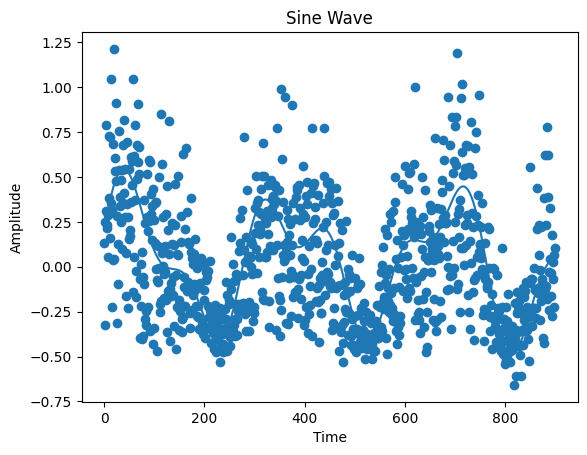

Epoch [210/1501] | d_loss: 0.1164 | g_loss: 0.1644
Epoch [220/1501] | d_loss: 0.0583 | g_loss: 0.1182
Epoch [230/1501] | d_loss: 0.0611 | g_loss: 0.3034
Epoch [240/1501] | d_loss: 0.0939 | g_loss: 0.2288
Epoch [250/1501] | d_loss: 0.0626 | g_loss: 0.2298
Epoch [260/1501] | d_loss: 0.0456 | g_loss: 0.2896
Epoch [270/1501] | d_loss: 0.0955 | g_loss: 0.1505
Epoch [280/1501] | d_loss: 0.0477 | g_loss: 0.2186
Epoch [290/1501] | d_loss: 0.0323 | g_loss: 0.1984
Epoch [300/1501] | d_loss: 0.0543 | g_loss: 0.3120
Epoch: 300 Generator Learning rate: 0.0016002664890073285
Epoch: 300 Discriminator Learning rate: 0.0024003997335109925


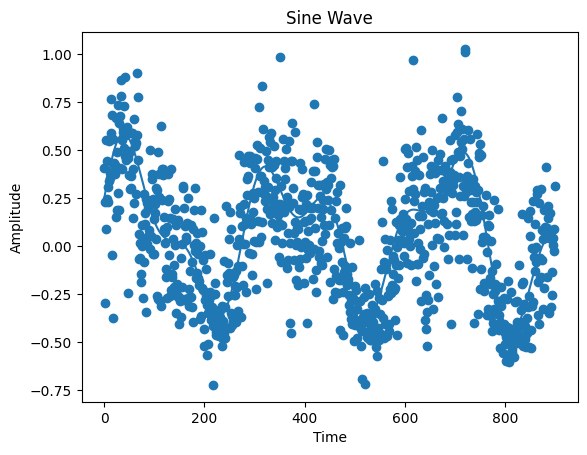

Epoch [310/1501] | d_loss: 0.0720 | g_loss: 0.1332
Epoch [320/1501] | d_loss: 0.0207 | g_loss: 0.3005
Epoch [330/1501] | d_loss: 0.0124 | g_loss: 0.2195
Epoch [340/1501] | d_loss: 0.0191 | g_loss: 0.2583
Epoch [350/1501] | d_loss: 0.0237 | g_loss: 0.2476
Epoch [360/1501] | d_loss: 0.0111 | g_loss: 0.2751
Epoch [370/1501] | d_loss: 0.0139 | g_loss: 0.2249
Epoch [380/1501] | d_loss: 0.0179 | g_loss: 0.1086
Epoch [390/1501] | d_loss: 0.0090 | g_loss: 0.3146
Epoch [400/1501] | d_loss: 0.0083 | g_loss: 0.3009
Epoch: 400 Generator Learning rate: 0.0014670219853431046
Epoch: 400 Discriminator Learning rate: 0.002200532978014657


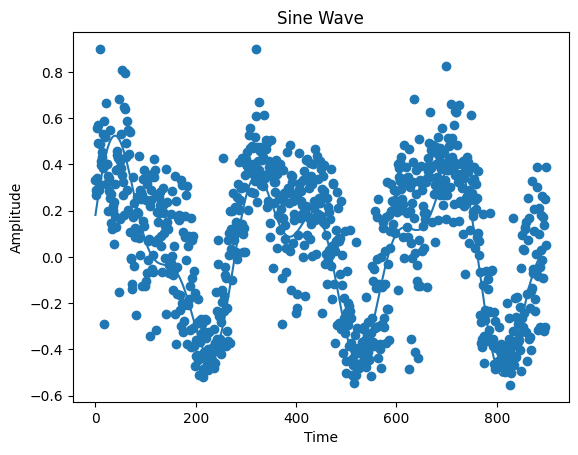

Epoch [410/1501] | d_loss: 0.0081 | g_loss: 0.2951
Epoch [420/1501] | d_loss: 0.0060 | g_loss: 0.2475
Epoch [430/1501] | d_loss: 0.0084 | g_loss: 0.2656
Epoch [440/1501] | d_loss: 0.0142 | g_loss: 0.3520
Epoch [450/1501] | d_loss: 0.0123 | g_loss: 0.2858
Epoch [460/1501] | d_loss: 0.0050 | g_loss: 0.2145
Epoch [470/1501] | d_loss: 0.0136 | g_loss: 0.3104
Epoch [480/1501] | d_loss: 0.0567 | g_loss: 0.1644
Epoch [490/1501] | d_loss: 0.9297 | g_loss: 0.1491
Epoch [500/1501] | d_loss: 0.3341 | g_loss: 0.1388
Epoch: 500 Generator Learning rate: 0.0013337774816788808
Epoch: 500 Discriminator Learning rate: 0.0020006662225183214


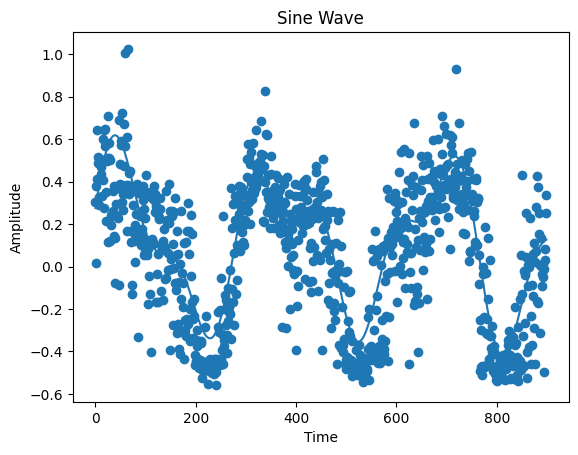

Epoch [510/1501] | d_loss: 0.0252 | g_loss: 0.1709
Epoch [520/1501] | d_loss: 0.0073 | g_loss: 0.2935
Epoch [530/1501] | d_loss: 0.0052 | g_loss: 0.3428
Epoch [540/1501] | d_loss: 0.0034 | g_loss: 0.1077
Epoch [550/1501] | d_loss: 0.0040 | g_loss: 0.1525
Epoch [560/1501] | d_loss: 0.0144 | g_loss: 0.2468
Epoch [570/1501] | d_loss: 0.0044 | g_loss: 0.4675
Epoch [580/1501] | d_loss: 0.0033 | g_loss: 0.3206
Epoch [590/1501] | d_loss: 0.0039 | g_loss: 0.3181
Epoch [600/1501] | d_loss: 0.0046 | g_loss: 0.2221
Epoch: 600 Generator Learning rate: 0.001200532978014657
Epoch: 600 Discriminator Learning rate: 0.0018007994670219854


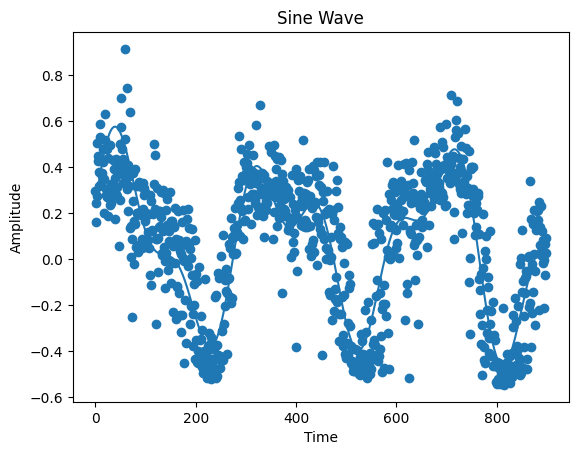

Epoch [610/1501] | d_loss: 0.0042 | g_loss: 0.1733
Epoch [620/1501] | d_loss: 0.0039 | g_loss: 0.2578
Epoch [630/1501] | d_loss: 0.0035 | g_loss: 0.1987
Epoch [640/1501] | d_loss: 0.0030 | g_loss: 0.2877
Epoch [650/1501] | d_loss: 0.0048 | g_loss: 0.2399
Epoch [660/1501] | d_loss: 0.0121 | g_loss: 0.1809
Epoch [670/1501] | d_loss: 0.0025 | g_loss: 0.1654
Epoch [680/1501] | d_loss: 0.0054 | g_loss: 0.5224
Epoch [690/1501] | d_loss: 0.4763 | g_loss: 0.3424
Epoch [700/1501] | d_loss: 0.4906 | g_loss: 0.2328
Epoch: 700 Generator Learning rate: 0.001067288474350433
Epoch: 700 Discriminator Learning rate: 0.0016009327115256496


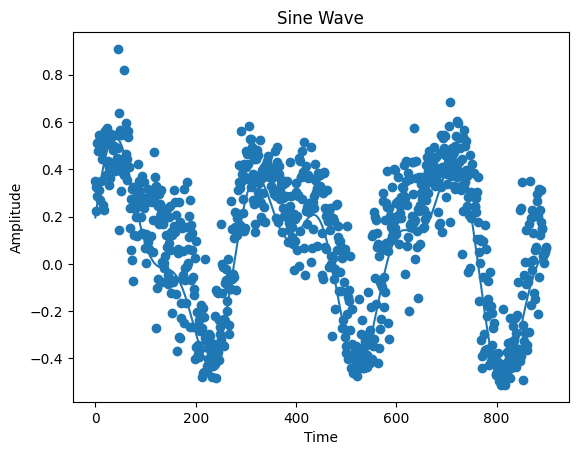

Epoch [710/1501] | d_loss: 0.3929 | g_loss: 0.2250
Epoch [720/1501] | d_loss: 0.4379 | g_loss: 0.2679
Epoch [730/1501] | d_loss: 0.6527 | g_loss: 0.2343
Epoch [740/1501] | d_loss: 0.3489 | g_loss: 0.3540
Epoch [750/1501] | d_loss: 0.2093 | g_loss: 0.3761
Epoch [760/1501] | d_loss: 0.0819 | g_loss: 0.8121
Epoch [770/1501] | d_loss: 0.1611 | g_loss: 0.5797
Epoch [780/1501] | d_loss: 0.0559 | g_loss: 0.6179
Epoch [790/1501] | d_loss: 0.0472 | g_loss: 0.5627
Epoch [800/1501] | d_loss: 0.0297 | g_loss: 0.4899
Epoch: 800 Generator Learning rate: 0.0009340439706862092
Epoch: 800 Discriminator Learning rate: 0.0014010659560293136


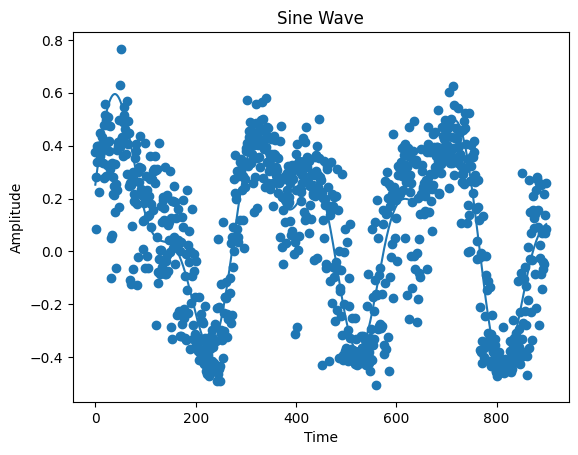

Epoch [810/1501] | d_loss: 0.2004 | g_loss: 0.9257
Epoch [820/1501] | d_loss: 0.0874 | g_loss: 0.3193
Epoch [830/1501] | d_loss: 0.0229 | g_loss: 0.7513
Epoch [840/1501] | d_loss: 0.0264 | g_loss: 0.7038
Epoch [850/1501] | d_loss: 0.0535 | g_loss: 0.1611
Epoch [860/1501] | d_loss: 0.2916 | g_loss: 0.4079
Epoch [870/1501] | d_loss: 0.0570 | g_loss: 0.5248
Epoch [880/1501] | d_loss: 0.0235 | g_loss: 0.7856
Epoch [890/1501] | d_loss: 0.0204 | g_loss: 0.7025
Epoch [900/1501] | d_loss: 0.0190 | g_loss: 0.6207
Epoch: 900 Generator Learning rate: 0.0008007994670219854
Epoch: 900 Discriminator Learning rate: 0.0012011992005329778


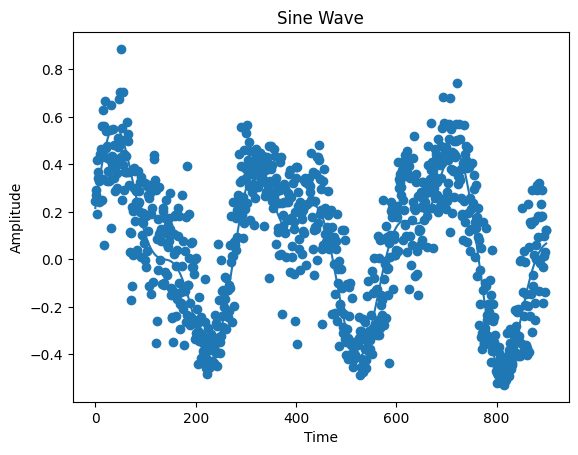

Epoch [910/1501] | d_loss: 0.0065 | g_loss: 0.5652
Epoch [920/1501] | d_loss: 0.0076 | g_loss: 0.3964
Epoch [930/1501] | d_loss: 0.0318 | g_loss: 0.5015
Epoch [940/1501] | d_loss: 0.0107 | g_loss: 0.8161
Epoch [950/1501] | d_loss: 0.0143 | g_loss: 0.6470
Epoch [960/1501] | d_loss: 0.0123 | g_loss: 0.6375
Epoch [970/1501] | d_loss: 0.0280 | g_loss: 0.5281
Epoch [980/1501] | d_loss: 0.0081 | g_loss: 0.3707
Epoch [990/1501] | d_loss: 0.0109 | g_loss: 0.5933
Epoch [1000/1501] | d_loss: 0.0197 | g_loss: 0.6919
Epoch: 1000 Generator Learning rate: 0.0006675549633577615
Epoch: 1000 Discriminator Learning rate: 0.0010013324450366423


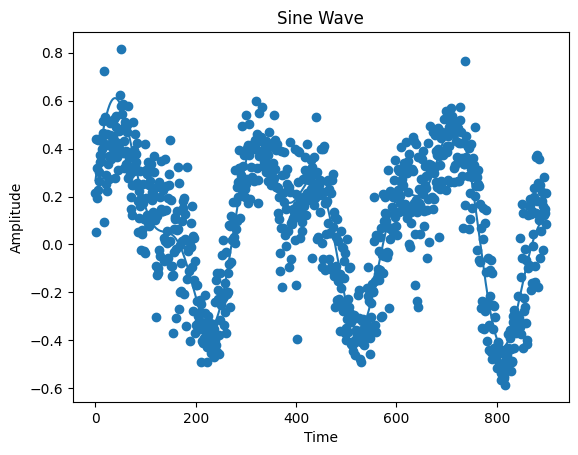

Epoch [1010/1501] | d_loss: 0.0079 | g_loss: 0.5464
Epoch [1020/1501] | d_loss: 0.0173 | g_loss: 0.6121
Epoch [1030/1501] | d_loss: 0.0110 | g_loss: 0.6091
Epoch [1040/1501] | d_loss: 0.0077 | g_loss: 0.6573
Epoch [1050/1501] | d_loss: 0.0450 | g_loss: 0.4995
Epoch [1060/1501] | d_loss: 0.0098 | g_loss: 0.6427
Epoch [1070/1501] | d_loss: 0.0056 | g_loss: 0.3735
Epoch [1080/1501] | d_loss: 0.0339 | g_loss: 0.5790
Epoch [1090/1501] | d_loss: 0.0226 | g_loss: 0.5666
Epoch [1100/1501] | d_loss: 0.0236 | g_loss: 0.6321
Epoch: 1100 Generator Learning rate: 0.0005343104596935374
Epoch: 1100 Discriminator Learning rate: 0.0008014656895403063


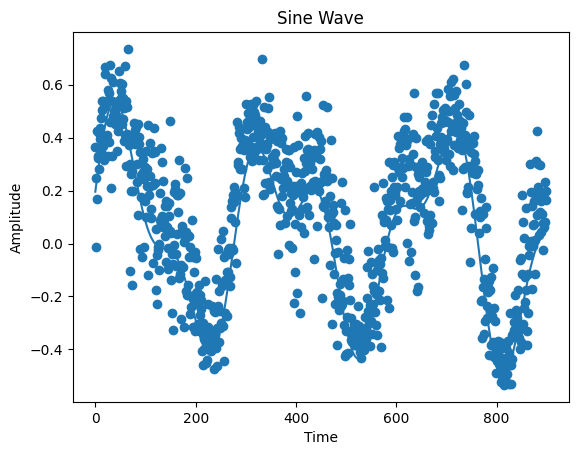

Epoch [1110/1501] | d_loss: 0.0048 | g_loss: 0.4304
Epoch [1120/1501] | d_loss: 0.0144 | g_loss: 0.8108
Epoch [1130/1501] | d_loss: 0.0028 | g_loss: 0.4336
Epoch [1140/1501] | d_loss: 0.0191 | g_loss: 0.6666
Epoch [1150/1501] | d_loss: 0.0210 | g_loss: 0.6169
Epoch [1160/1501] | d_loss: 0.0320 | g_loss: 0.5438
Epoch [1170/1501] | d_loss: 0.0044 | g_loss: 0.6346
Epoch [1180/1501] | d_loss: 0.0029 | g_loss: 0.5762
Epoch [1190/1501] | d_loss: 0.0225 | g_loss: 0.4794
Epoch [1200/1501] | d_loss: 0.0318 | g_loss: 0.5157
Epoch: 1200 Generator Learning rate: 0.0004010659560293136
Epoch: 1200 Discriminator Learning rate: 0.0006015989340439707


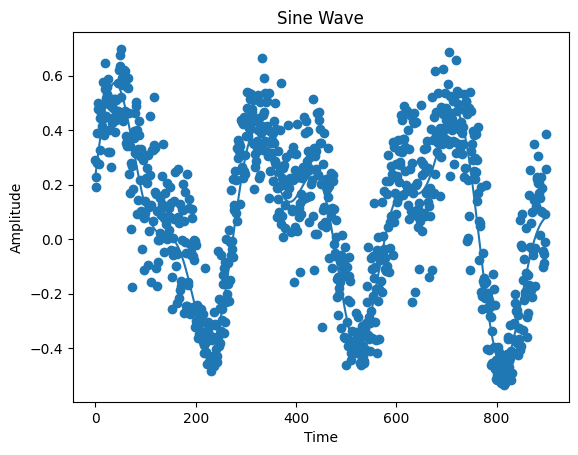

Epoch [1210/1501] | d_loss: 0.0387 | g_loss: 0.5513
Epoch [1220/1501] | d_loss: 0.0201 | g_loss: 0.3329
Epoch [1230/1501] | d_loss: 0.0088 | g_loss: 0.4824
Epoch [1240/1501] | d_loss: 0.0217 | g_loss: 0.4391
Epoch [1250/1501] | d_loss: 0.0101 | g_loss: 0.4512
Epoch [1260/1501] | d_loss: 0.0152 | g_loss: 0.2932
Epoch [1270/1501] | d_loss: 0.0572 | g_loss: 0.5528
Epoch [1280/1501] | d_loss: 0.0109 | g_loss: 0.6384
Epoch [1290/1501] | d_loss: 0.0351 | g_loss: 0.1793
Epoch [1300/1501] | d_loss: 0.0111 | g_loss: 0.4823
Epoch: 1300 Generator Learning rate: 0.00026782145236508973
Epoch: 1300 Discriminator Learning rate: 0.0004017321785476347


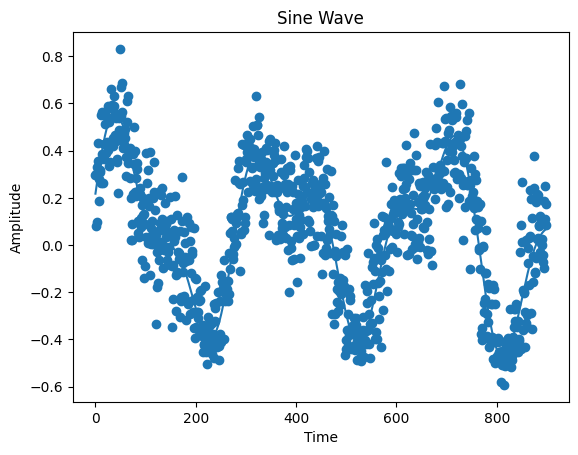

Epoch [1310/1501] | d_loss: 0.0073 | g_loss: 0.4157
Epoch [1320/1501] | d_loss: 0.0537 | g_loss: 0.3438
Epoch [1330/1501] | d_loss: 0.0142 | g_loss: 0.8218
Epoch [1340/1501] | d_loss: 0.0254 | g_loss: 0.7230
Epoch [1350/1501] | d_loss: 0.0161 | g_loss: 0.6175
Epoch [1360/1501] | d_loss: 0.0200 | g_loss: 0.4988
Epoch [1370/1501] | d_loss: 0.0249 | g_loss: 0.2871
Epoch [1380/1501] | d_loss: 0.0171 | g_loss: 0.4485
Epoch [1390/1501] | d_loss: 0.0180 | g_loss: 0.3641
Epoch [1400/1501] | d_loss: 0.0510 | g_loss: 0.6076
Epoch: 1400 Generator Learning rate: 0.00013457694870086588
Epoch: 1400 Discriminator Learning rate: 0.00020186542305129914


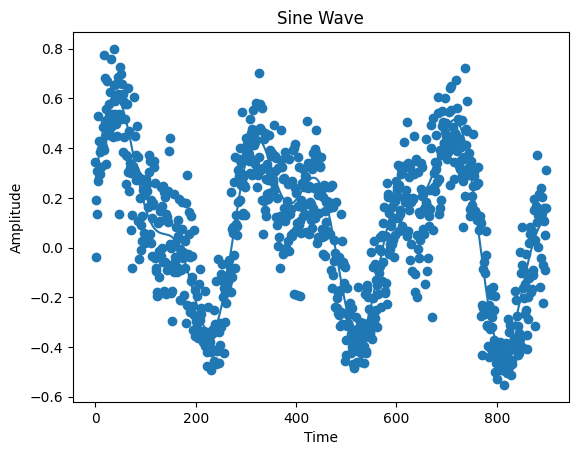

Epoch [1410/1501] | d_loss: 0.0338 | g_loss: 0.4062
Epoch [1420/1501] | d_loss: 0.0325 | g_loss: 0.4189
Epoch [1430/1501] | d_loss: 0.0261 | g_loss: 0.4624
Epoch [1440/1501] | d_loss: 0.0385 | g_loss: 0.3362
Epoch [1450/1501] | d_loss: 0.0421 | g_loss: 0.4053
Epoch [1460/1501] | d_loss: 0.0472 | g_loss: 0.3425
Epoch [1470/1501] | d_loss: 0.0330 | g_loss: 0.3967
Epoch [1480/1501] | d_loss: 0.0348 | g_loss: 0.4603
Epoch [1490/1501] | d_loss: 0.0267 | g_loss: 0.4175
Epoch [1500/1501] | d_loss: 0.0421 | g_loss: 0.3789
Epoch: 1500 Generator Learning rate: 1.3324450366422429e-06
Epoch: 1500 Discriminator Learning rate: 1.9986675549631475e-06


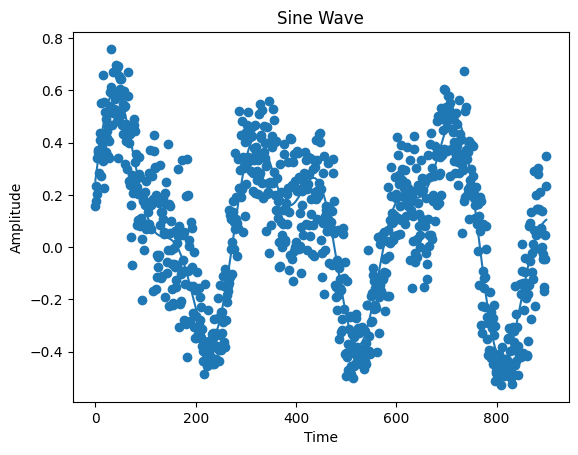

In [56]:
g_losses = []
d_losses = []
for epoch in range(num_epochs):
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()
    for i, x in enumerate(dataloader):
        
        real_x = torch.cat(x, dim=0).to(device)

        # Train the discriminator
        discriminator.zero_grad()
        #real_x = x[i].type(torch.FloatTensor)
        z = torch.FloatTensor(np.random.uniform(-1, 1, (batch_size, latent_dim))).to(device)
        fake_x = generator(z).detach()
        #real_x = real_x.unsqueeze(1).float().to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        ##print(real_x)
        real_output = discriminator(real_x)
        #print(real_output.shape)
        d_loss_real = criterion(real_output, real_labels)

        # Train on fake data
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_x = generator(z).detach()
        fake_output = discriminator(fake_x)
        d_loss_fake = criterion(fake_output, fake_labels)

        # Compute the total discriminator loss and optimize the discriminator
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train the generator
        generator.zero_grad()

        #z = torch.randn(batch_size, latent_dim).to(device)
        z = torch.FloatTensor(np.random.uniform(-1, 1, (batch_size, latent_dim))).to(device)
        fake_x = generator(z)
        fake_output = discriminator(fake_x)

        # Compute the generator loss and optimize the generator
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        g_optimizer.step()


    g_scheduler.step(epoch)
    d_scheduler.step(epoch)
    # Print the loss values
    generator.eval()
    if epoch % 10 == 0:
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        print(f"Epoch [{epoch}/{num_epochs}] | d_loss: {d_loss.item():.4f} | g_loss: {g_loss.item():.4f}")

        if epoch % 100 == 0:

          print('Epoch:', epoch, 'Generator Learning rate:', g_optimizer.param_groups[0]['lr'])
          print('Epoch:', epoch, 'Discriminator Learning rate:', d_optimizer.param_groups[0]['lr'])

          fake = np.reshape(fake_x.detach().cpu().numpy(), (batch_size, seq_len))
          real = np.reshape(real_x.detach().cpu().numpy(), (batch_size, seq_len))

          plt.plot(fake[i,:], label = 'fake', color = 'blue' )
          plt.plot(real[i,:],label = 'real', color = 'red')
          plt.xlabel('Time')
          plt.ylabel('Amplitude')
          plt.title('Generated Wave')
          plt.legend()
          plt.show()

#save the model in the drive 
save_path = '/content/gdrive/My Drive/final project/saved models/model.pt'
torch.save(generator.state_dict(), save_path)


#Evaluation 

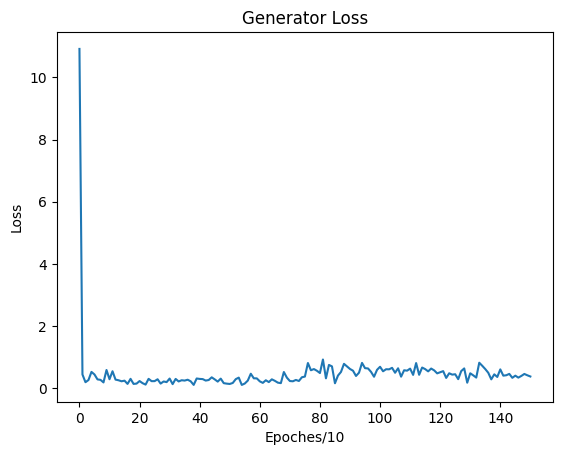

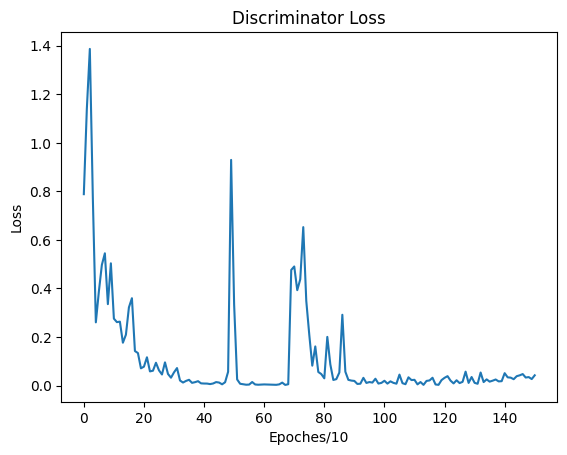

In [57]:
n = len(g_losses)
plt.plot(range(n),g_losses)
plt.xlabel('Epoches/10')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.show()

plt.plot(range(n),d_losses)
plt.xlabel('Epoches/10')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.show()

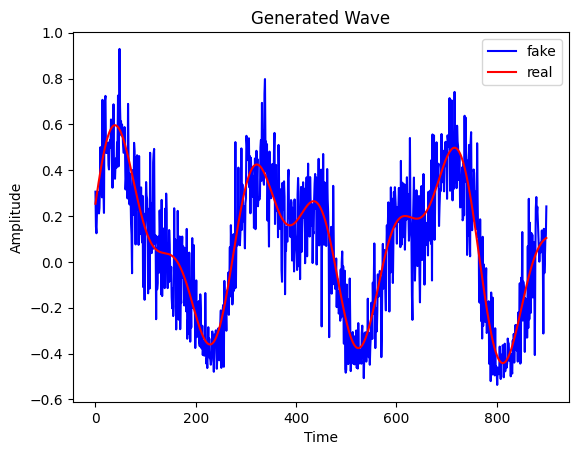

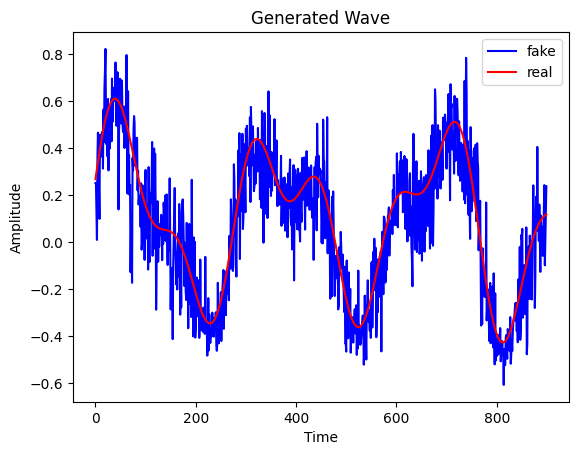

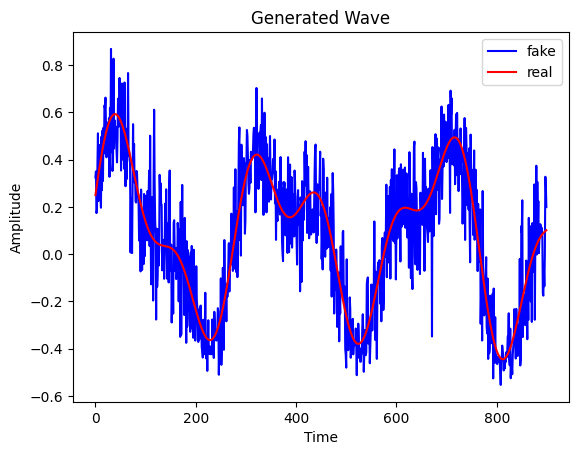

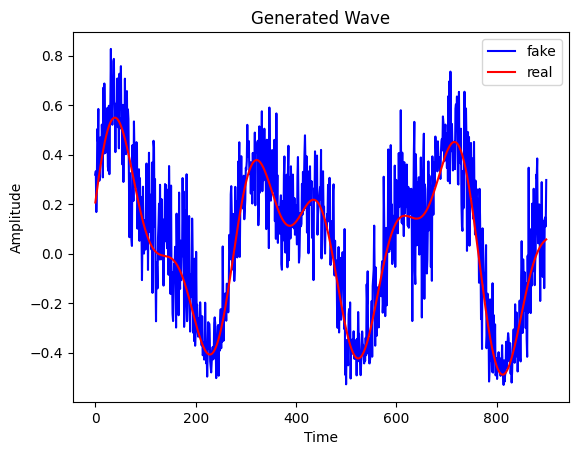

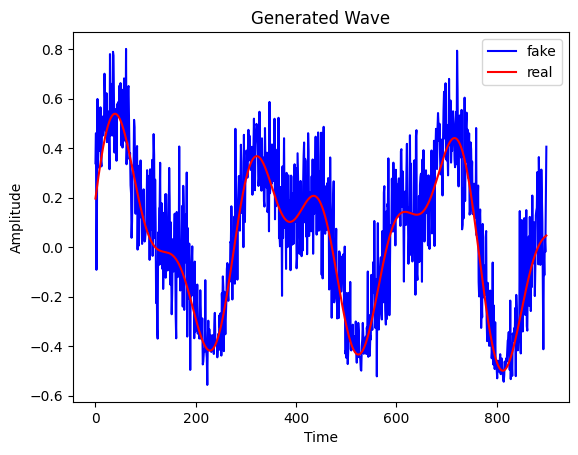

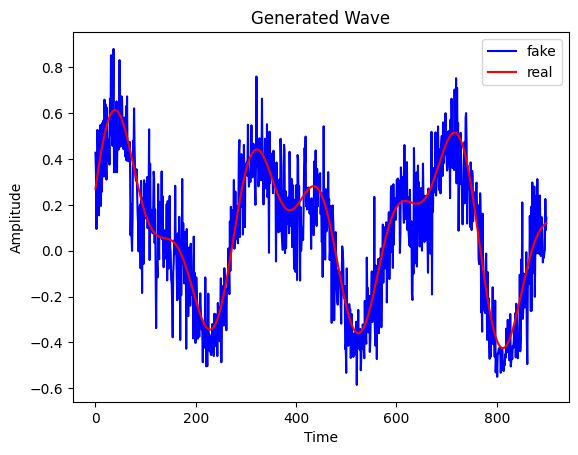

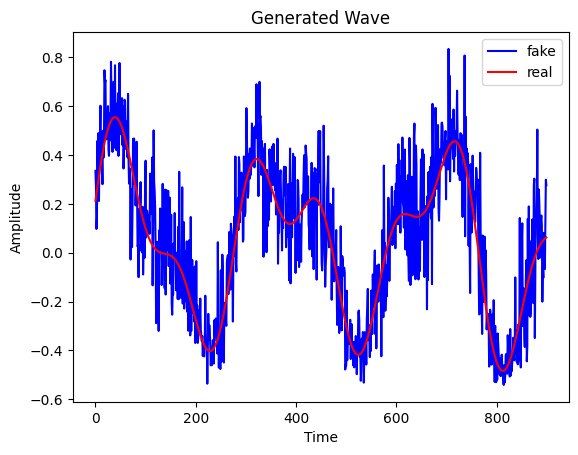

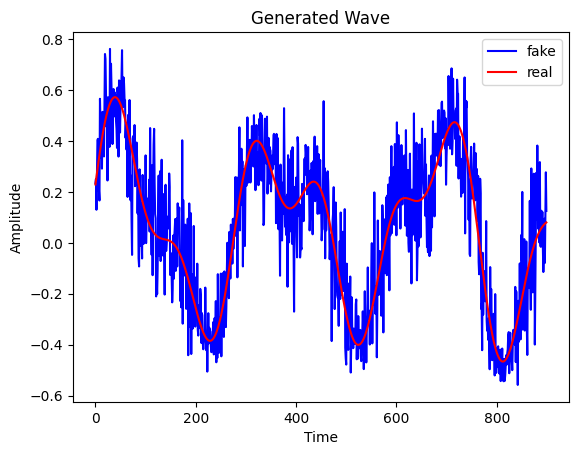

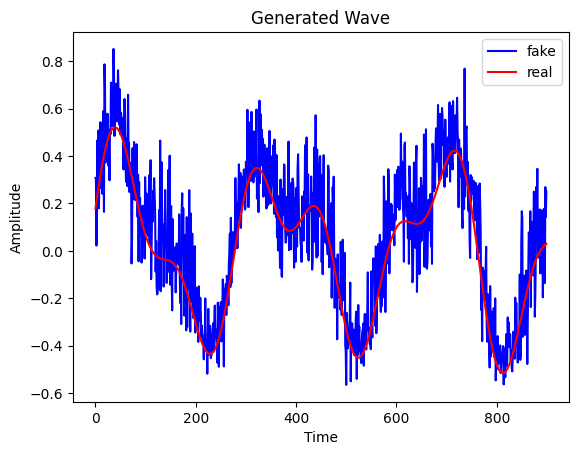

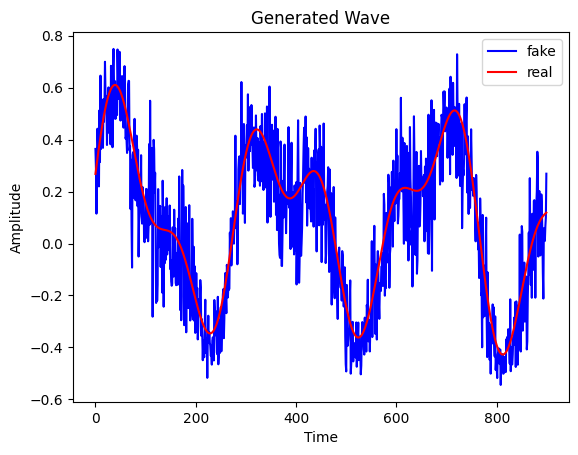

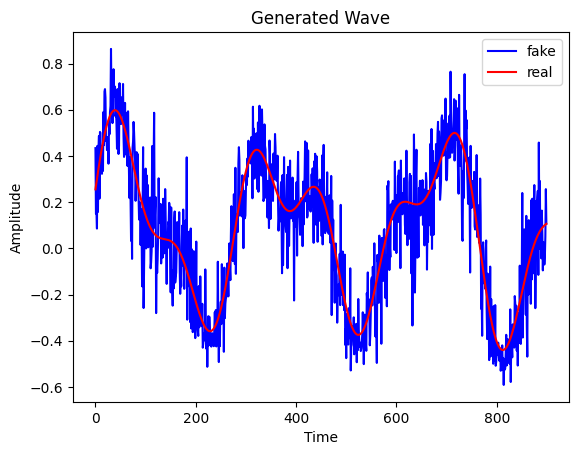

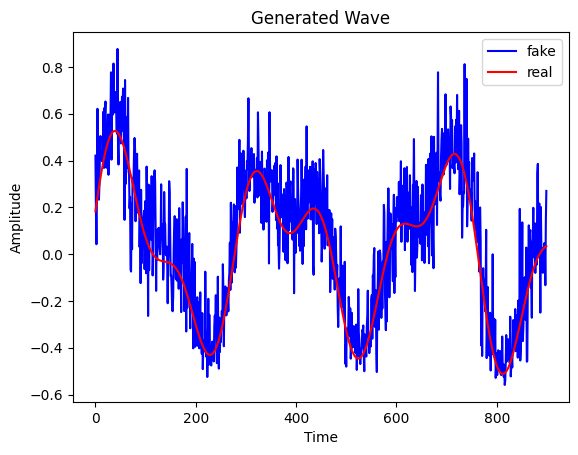

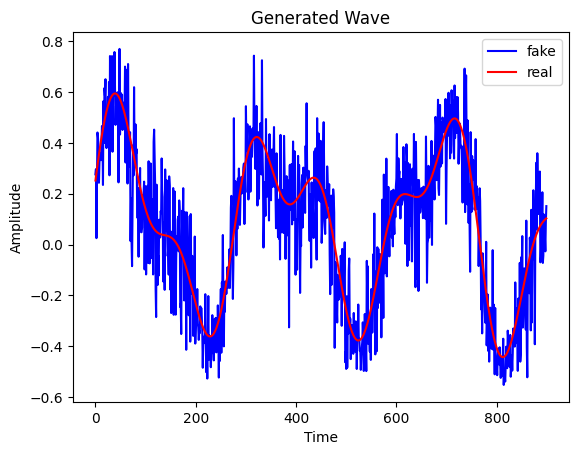

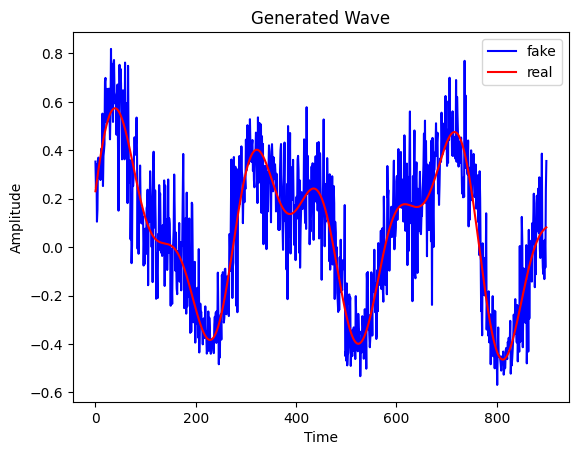

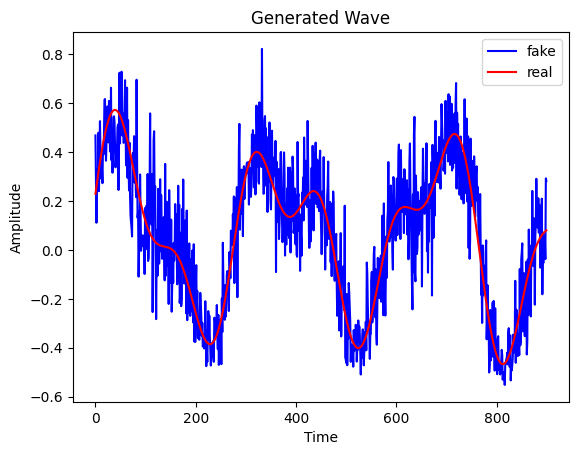

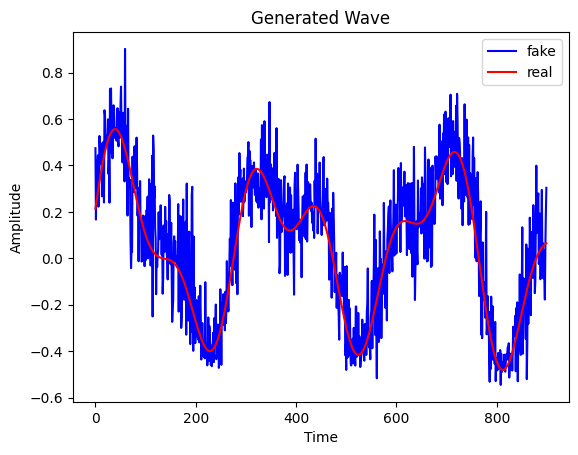

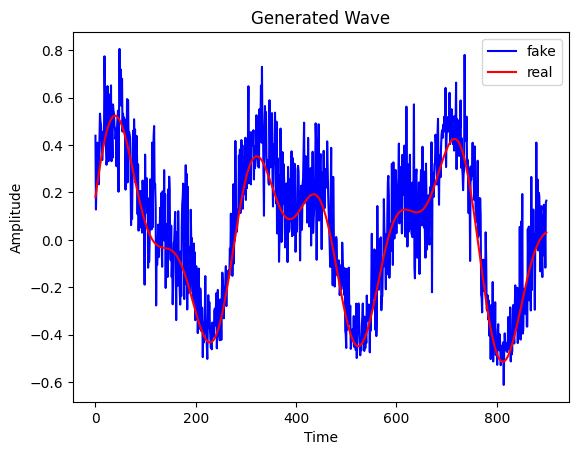

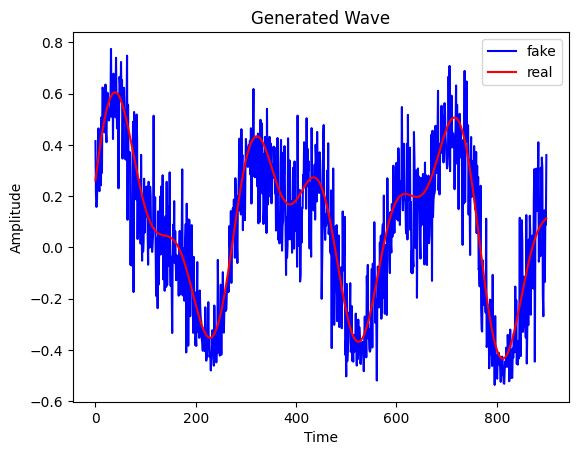

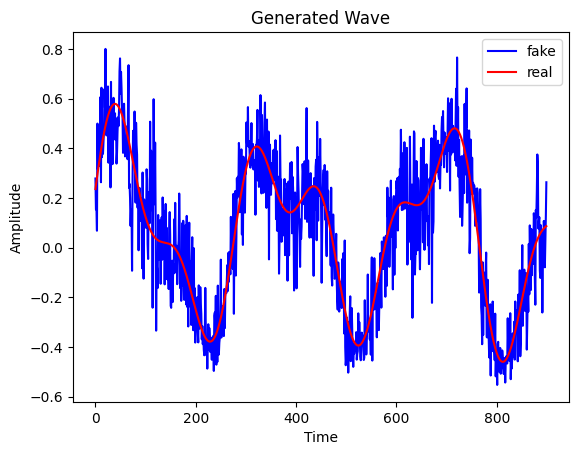

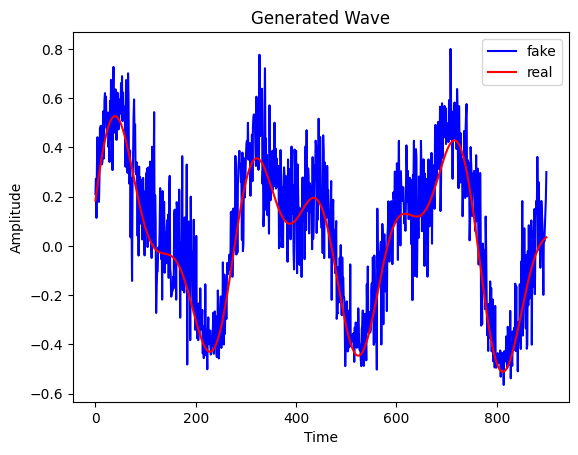

In [88]:
z = torch.FloatTensor(np.random.uniform(-1, 1, (batch_size, latent_dim))).to(device)
fake_x = generator(z)
fake = np.reshape(fake_x.detach().cpu().numpy(), (batch_size, seq_len))
real = np.reshape(real_x.detach().cpu().numpy(), (batch_size, seq_len))
for i in range(20):
    plt.plot(fake[i,:], label = 'fake', color = 'blue' )
    plt.plot(real[i,:],label = 'real', color = 'red')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Generated Wave')
    plt.legend()
    plt.show()

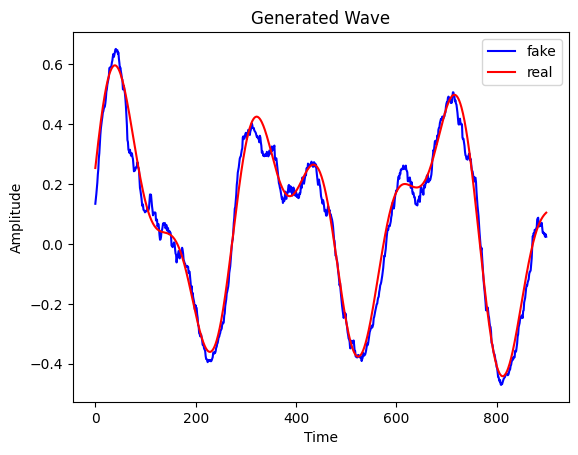

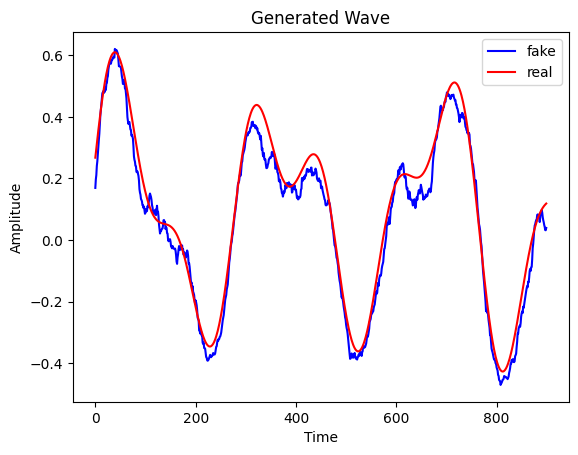

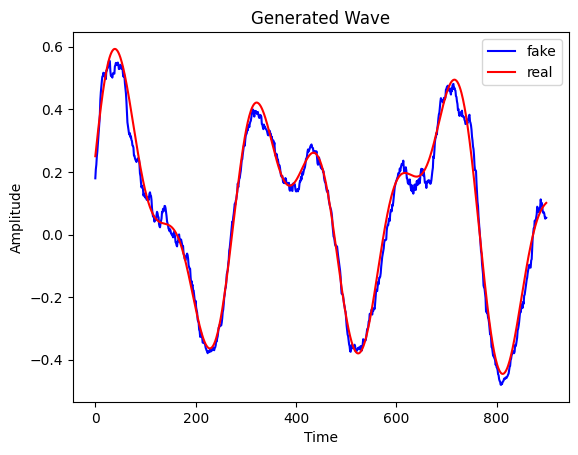

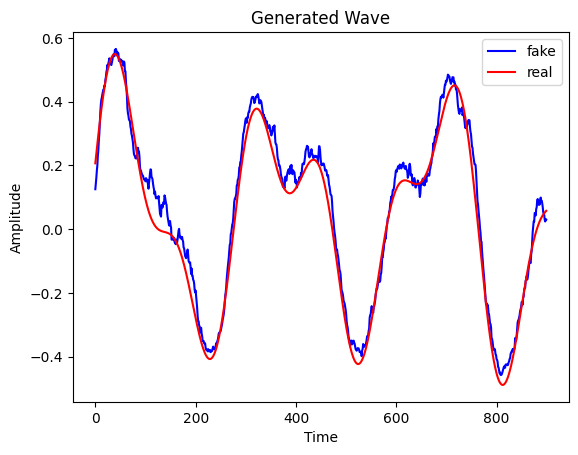

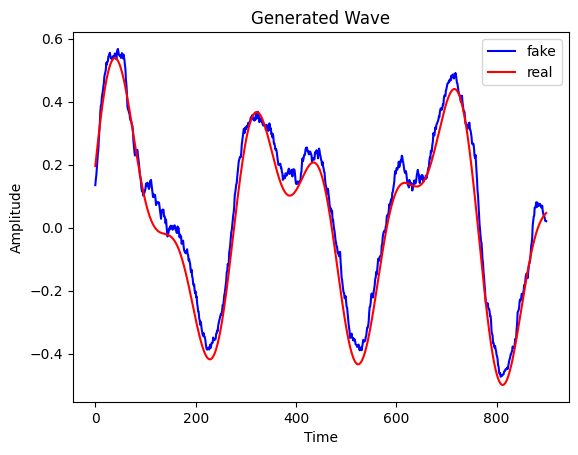

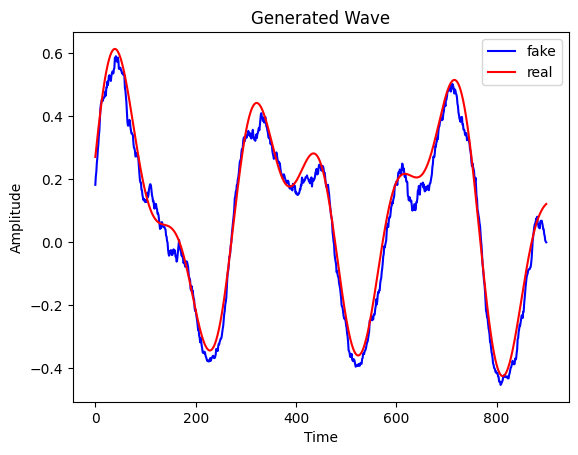

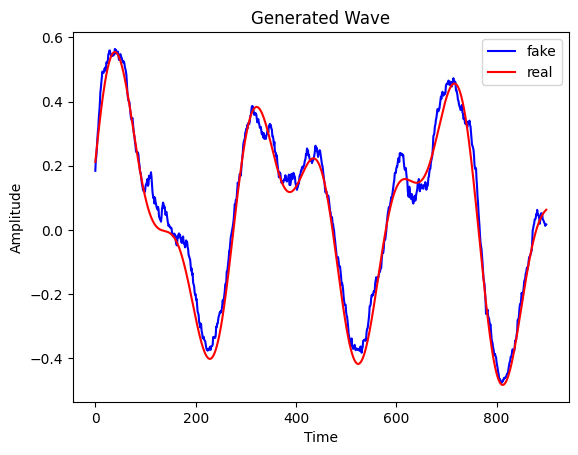

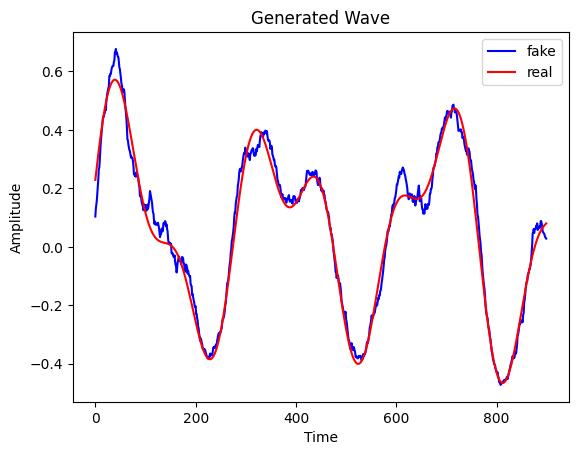

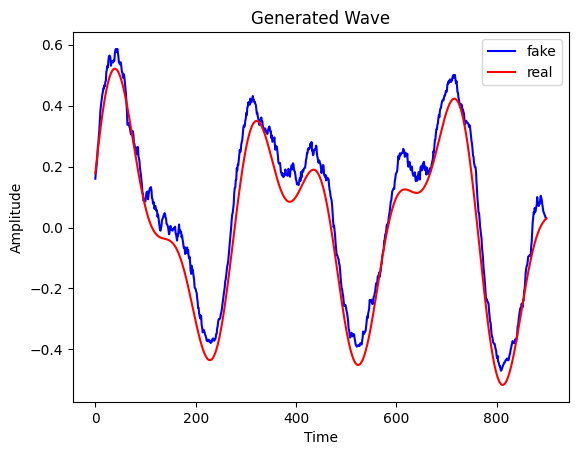

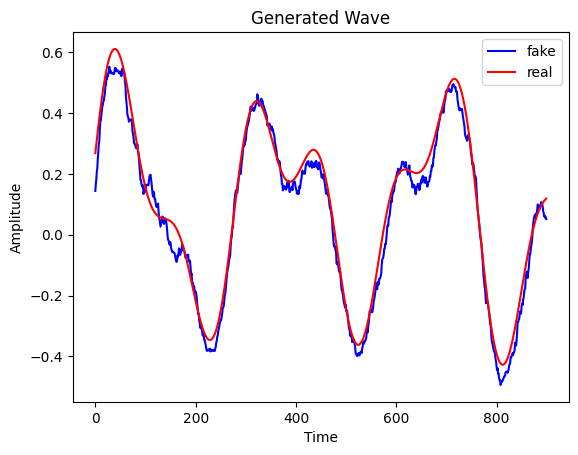

In [84]:
#smooth the data with moving avarage
window_size = 20  # choose the size of the moving average window
window = np.ones(window_size) / window_size
#smoothed_data = np.convolve(fake, window, mode='same')
for i in range(10):
    smoothed_data = np.convolve(fake[i,:], window, mode='same')
    plt.plot(smoothed_data, label = 'fake', color = 'blue' )
    plt.plot(real[i,:],label = 'real', color = 'red')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Generated Wave')
    plt.legend()
    plt.show()


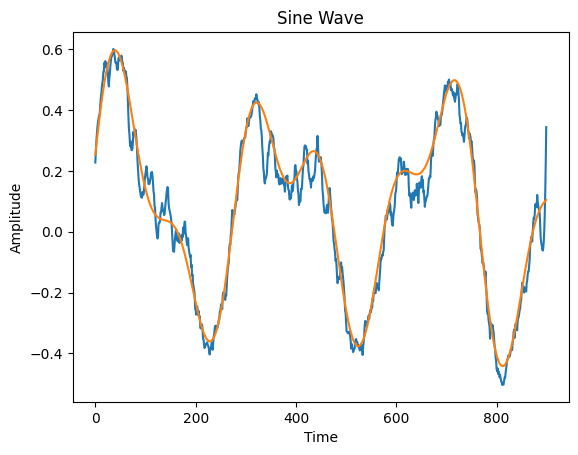

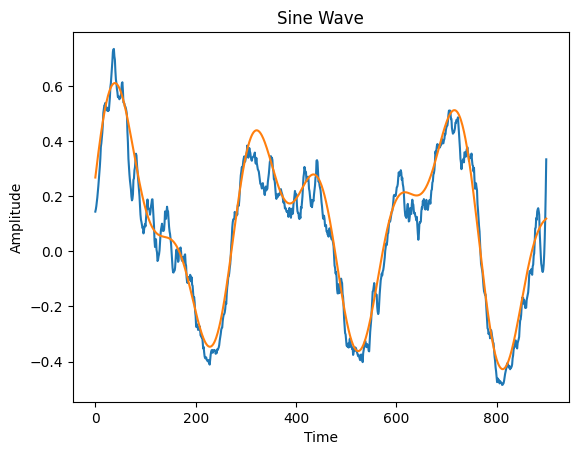

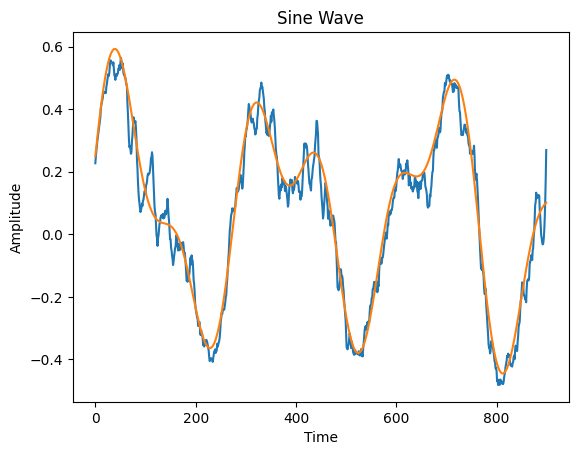

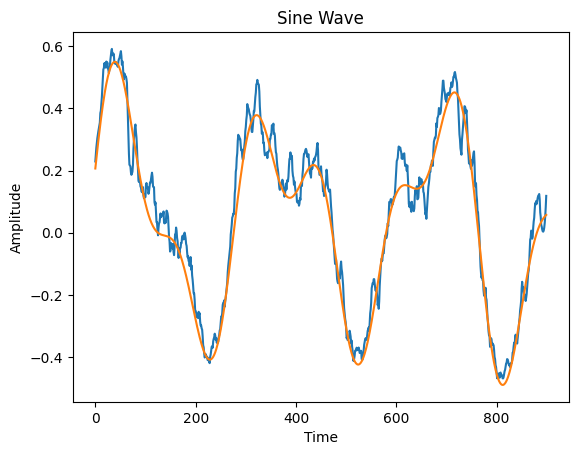

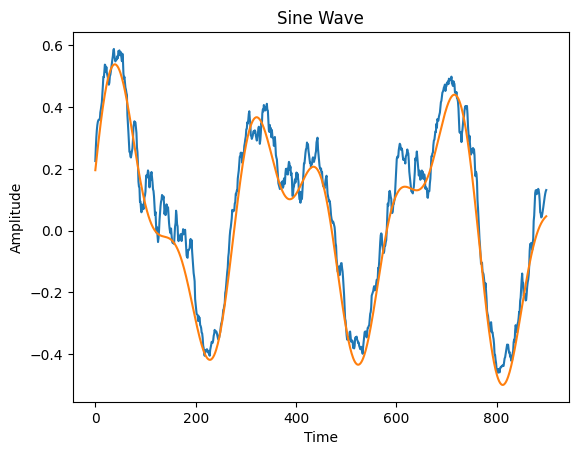

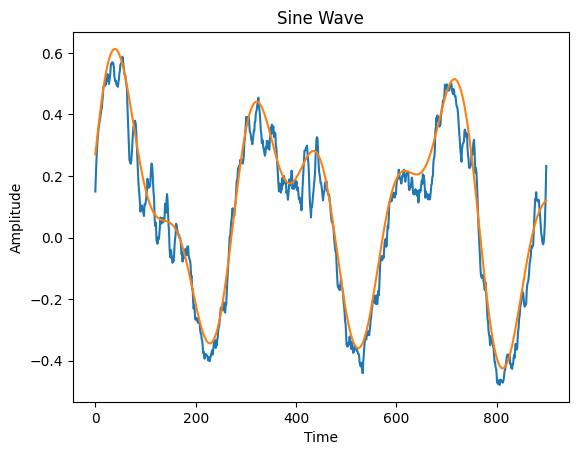

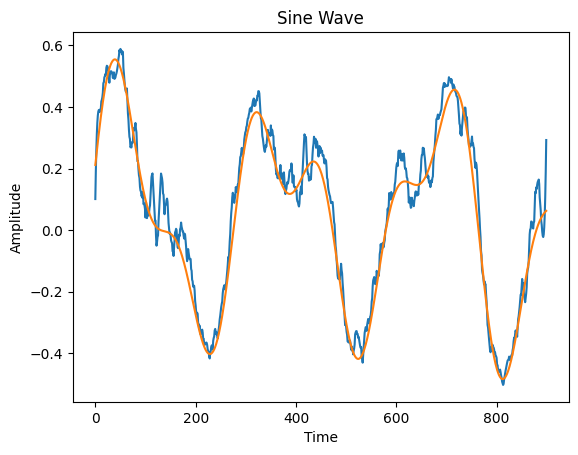

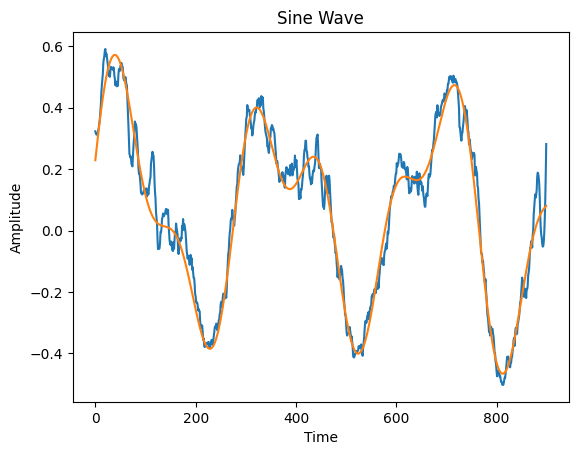

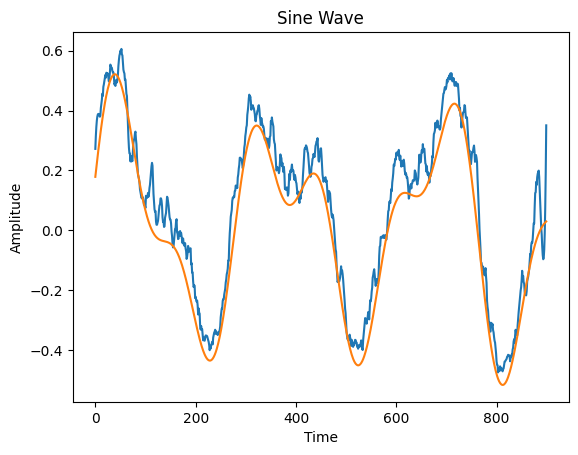

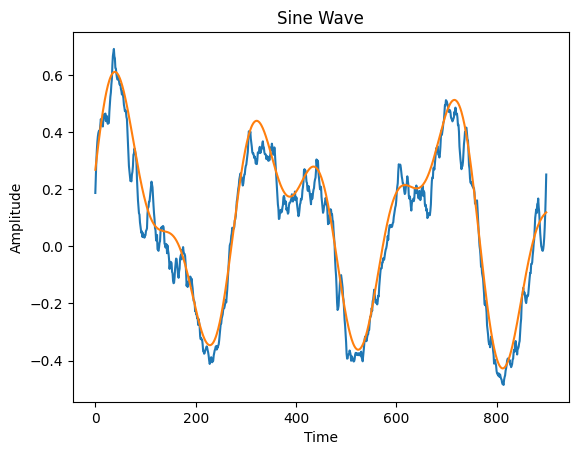

In [62]:
#smooth the data with Savitzky-Golay filter
from scipy.signal import savgol_filter

window_size = 20  # choose the size of the Savitzky-Golay window
poly_order = 3  # choose the degree of the polynomial
for i in range(10):
    smoothed_data = savgol_filter(fake[i,:], window_size, poly_order)
    plt.plot(smoothed_data)
    plt.plot(real[i,:])
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Sine Wave')
    plt.show()


cosine similarity calculation

In [75]:
def cosine_similarity(x, y):
    return F.cosine_similarity(x, y, dim=1)

# Generate a batch of fake data
fake_data = generator(z)

# Convert fake_data tensor to device
fake_data = fake_data.to(device)
fake = fake_data.detach().clone()
real = torch.as_tensor(real, device=device)

cos_sim = F.cosine_similarity(real, fake, dim=1)

# Calculate average cosine similarity
avg_cos_sim = cos_sim.mean().item()

print(f"Average cosine similarity: {avg_cos_sim}")


Average cosine similarity: 0.7662847638130188


Average Jensen-Shannon distance calculation

In [76]:
from sklearn.neighbors import KernelDensity
import numpy as np
import torch.nn.functional as F

def jensen_shannon_distance(x, y):
    M = 0.5 * (x + y)
    return 0.5 * (F.kl_div(x, M, reduction='batchmean') + F.kl_div(y, M, reduction='batchmean'))

# Generate a batch of fake data
fake_data = generator(z)

# Compute kernel density estimate of real and fake data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
kde.fit(real)
real_pdf = np.exp(kde.score_samples(real))

kde.fit(fake_data.detach().numpy())
fake_pdf = np.exp(kde.score_samples(fake_data.detach().numpy()))

# Compute average PDF
avg_pdf = 0.5 * (real_pdf + fake_pdf)

# Compute Jensen-Shannon distance
jsd = jensen_shannon_distance(torch.tensor(real_pdf), torch.tensor(fake_pdf))

# Calculate average Jensen-Shannon distance
avg_jsd = jsd.mean().item()

print(f"Average Jensen-Shannon distance: {avg_jsd}")

TypeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Ect

In [ ]:
for epoch in range(num_epochs):
    for i, x in enumerate(dataloader):
        z = torch.FloatTensor(np.random.uniform(0, 1, (batch_size, latent_dim))).to(device)

        real_x = torch.cat(x, dim=0).to(device)
        #real_x = x.type(torch.FloatTensor).to(device)

        # Train the discriminator
        real_val = discriminator(real_x)
        fake_output = generator(z).detach()
        fake_val = discriminator(fake_output)
        if isinstance(fake_val, list):
            d_loss = 0
            for real_validity_item, fake_validity_item in zip(real_val, fake_val):
                real_label = torch.full((real_validity_item.shape[0],real_validity_item.shape[1]), 1., dtype=torch.float)
                fake_label = torch.full((real_validity_item.shape[0],real_validity_item.shape[1]), 0., dtype=torch.float)
                d_real_loss = nn.MSELoss()(real_validity_item, real_label)
                d_fake_loss = nn.MSELoss()(fake_validity_item, fake_label)
                d_loss += d_real_loss + d_fake_loss
        else:
            real_label = torch.full((real_val.shape[0],real_val.shape[1]), 1., dtype=torch.float)
            fake_label = torch.full((real_val.shape[0],real_val.shape[1]), 0., dtype=torch.float)
            d_real_loss = nn.MSELoss()(real_val, real_label)
            d_fake_loss = nn.MSELoss()(fake_val, fake_label)
            d_loss = d_real_loss + d_fake_loss

        d_loss.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 5.)
        d_optimizer.step()
        d_optimizer.zero_grad()

        # Train the generator
        gen_z = torch.FloatTensor(np.random.uniform(0, 1, (batch_size, latent_dim)))
        gen_imgs = generator(gen_z)
        fake_val = discriminator(gen_imgs)

        if isinstance(fake_val, list):
            g_loss = 0
            for fake_validity_item in fake_val:
                real_label = torch.full((fake_validity_item.shape[0],fake_validity_item.shape[1]), 1., dtype=torch.float)
                g_loss += nn.MSELoss()(fake_validity_item, real_label)
        else:
            real_label = torch.full((fake_val.shape[0],fake_val.shape[1]), 1., dtype=torch.float)
            g_loss = nn.MSELoss()(fake_val, real_label)

        torch.nn.utils.clip_grad_norm_(generator.parameters(), 5.)
        g_optimizer.step()
        g_optimizer.zero_grad()

    #############################################################################################

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}] | d_loss: {d_loss.item():.4f} | g_loss: {g_loss.item():.4f}")
        if epoch % 100 == 0:
            true_samples = np.sin(np.linspace(-np.pi, np.pi, 150))
            data = np.reshape(gen_imgs.detach().numpy(), (batch_size, 150))
            plt.plot(data[i,:])
            plt.plot(true_samples)
            plt.xlabel('Time')
            plt.ylabel('Amplitude')
            plt.title('Sine Wave')
            plt.show()
